## Final Project - Approximate RL and Deep QLearning With Lunar Lander
### CSPB 3202 - Intro to AI, Spring 2025
##### Sulman Haque

##### https://github.com/suha1419/FinalProjectLunarLander

#### Project Overview

The goal for this assignment was to develop and test different Reinforcement Learning approaches in the gymnasium environment provided by OpenAI.
The RL approaches we will review are:
1) Approximate Q-Learning
2) Deep Q-Learning

The environment we selected was LunarLander. 
The goal of lunar lander is to land a rocket in the deisred location in a safe and stable manner. 

We compare the performance of two instances of the Approximate Q-Learning, one with no engineered features and one with engineered features.
Next we compare the performance of a Deep Q-Network Model.
Our evaluation is primarily to maximize reward via policy convergence but also qualitatively observe agent performance.

#### Approach

##### Environment

The lunar lander environment is a continouous space, discrete action environment:

It provides a continuous observiation space that includes:
1) Continuous:  x coordinate
2) Continuous:  y coordinate 
3) Continuous:  x velocity
4) Continuous:  y velocity
5) Continuous:  angle
6) Continuous:  angular velocity
7) Boolean:     left leg on ground
8) Boolean:     right leg on ground


The action space consits of a discrete set of actions:
1) nothing
2) fire left engine
3) fire main engine
4) fire right engine


The rewards structure are as follows:
1) increased/decreased the closer/further the lander is to the landing pad.
2) increased/decreased the slower/faster the lander is moving.
3) decreased the more the lander is tilted (angle not horizontal).
4) increased by 10 points for each leg that is in contact with the ground.
5) decreased by 0.03 points each frame a side engine is firing.
6) decreased by 0.3 points each frame the main engine is firing.
7) The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
8) An episode is considered a solution if it scores at least 200 points.

**Q-Learning Overview**

Q-Learning is one of the primary active, model-free, methods in reinforcment learning taught in an introductory course in AI. 

* Active approaches imply the agent is learning some policy that seeks to maximize the reward for the next state-action pair, as opposed to passive approaches that only seek to evaluate given policies.

* Model-free approaches implies the agent is not directly learning a model of the environment, rather determining Q-values and selecting the state-action pair that maximizes these Q-values for the policy. But what does that really mean? In a model-based approach, the agent is essentially learning a representation of the world independent of any rewards. It can learn what states follow other given states, what is the probability of landing on that state given an action, etc. It can learn all this without any regard to the underlying reward structure. In contrast, the model-free methods bypass any independent effort to develop a learned representation of the world. Instead, it is directly learning how to maximize the reward by any means necessary. This is useful because it is often the case that many environments do not have an explict model of the world to offer an agent, and learning it may be computationally infeasible. So model-free active approaches provide a framework for learning-based agents to operate in an environment whose complexity is too difficult to learn. However, this also implies the agents do not necessarily translate well into new environments, as the Q-Values associated with actions will presumably be very different from world to world. A model based method would at least have some transfer learning based on the world-model being built.



**Approximate Q-Learning**

Approximate Q-Learning extends the base idea of Q-Learning, where an agent is looking to maximize a state-action pair to improve some policy, only this approach uses function approximation to determine values of states as opposed to calculating them through tabular / dynamic programming methods as in regular Q-Learning. 
Often state spaces (Lunar Lander) are so large it becomes computationally infeasible to store and compute with tabular methods.

The idea is straightforward: we represent the Q-values as a weight sum of features extracted from a state-action pair. 

$$Q(s, a) = \sum_{i} w_i \, f_i(s, a)$$

As the agent interacts with the environment, it updates the weights based on the error between predicted and actual rewards. 

$$w_i \leftarrow w_i + \alpha \, \delta \, f_i(s,a)$$


In our effort, we use the state/features space provided by Lunar Lander initially and evaluate performance. 

Then we compute the following features and reevaluate:
1) Distance from center
2) Speed
3) Angular momentum
4) Both legs touching ground
5) Lander stability


We have some flexibility with weights and can serve as hyperparameter adjustments going foward.


**Deep Q-Learning**


The core idea behind Deep Q-Learning builds directly on Approximate Q-Learning, where the value of state-action pairs is replaced by a function. Instead of a simple linear function, Deep Q-Learning uses a deep neural network to approximate Q(s,a). This allows the agent to learn directly from raw state inputs without the need for manually engineered features. The neural network allows for the agent to learn non-linear relationships in the state-action space that would not be captured in the simple approximate Q-learning agents.

The general idea is the same, the agent will select state-action pairs that maximize the total expected return. Through successive episodes, the agent will store the interactions / results and periodically update the neural network. The size of the replay buffer for storing previous samples and period of updating are also hyperparameters that can be tuned.

During action selection, the agent will run the current state through a policy NN and receive an output on the best action to take and subsequently take that action. A seperate target NN is maintained that provide periodic updates to policy NN to provide more stability, reduce bias and drive towards convergence in the neural network. This helps to reduce osciallations and instability during the learning.

Updating the policy network takes three steps:

1) Calcualte the Target Q-value via Bellman Equation:


   $$y = r + \gamma \max_{a'} Q_{\text{target}}(s',a')$$ 


2) Loss Function (MSE)

   $$\mathcal{L}(\theta) = \mathbb{E}[(y - Q_{\text{policy}}(s,a;\theta))^2]$$



3) Gradient Descent Update:

    $$\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta)$$   


This framework allows DQN to scale Q-learning to high-dimensional problems while improving sample efficiency and training stability.


#### Approximate Q-Learning Agent

In [9]:
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from tqdm import trange
from IPython.display import Image, display


class ApproximateQLunarLander:
    def __init__(self, env_name='LunarLander-v2', alpha=0.01, gamma=0.99, epsilon_start=1.0, epsilon_end=0.05, 
                 epsilon_decay=0.995,use_engineered_features=False,seed=42,weights_path='linear_q_weights.pth'):

        # INITIALIZE VARIABLES
        self.env = gym.make(env_name, render_mode='rgb_array')
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.use_engineered_features = use_engineered_features
        self.seed = seed
        self.weights_path = weights_path

        np.random.seed(seed)
        torch.manual_seed(seed)

        # INITIALIZE DIMENSIONS
        dummy_state, _ = self.env.reset(seed=seed)
        feature_dim = self.compute_features(dummy_state).shape[0]
        action_dim = self.env.action_space.n

        # WEIGHTS: ONE WEIGHT SET FOR EACH ACTION
        self.weights = torch.zeros((action_dim, feature_dim), dtype=torch.float32)
        self.best_weights = torch.zeros((action_dim, feature_dim), dtype=torch.float32)


    def compute_features(self, state):

        # USE BASE FEATURES
        if not self.use_engineered_features:
            return torch.tensor(state, dtype=torch.float32)
        else:
            # CALCULATED ENGINEERD FEATURES
            x, y, vx, vy, angle, angular_velocity, left_contact, right_contact = state
            # DISTANCE FROM CENTER
            distance_from_center = abs(x)
            # SPEED
            speed = np.sqrt(vx**2 + vy**2)
            # ANGULAR MOMENTUM
            angular_momentum = angle * angular_velocity

            # BOTH LEGS TOUCHING GROUND
            legs_difference = abs(left_contact - right_contact)

            # UPRIGHTNESS
            uprightness = abs(angle)

            # RETURN AS TORCH
            return torch.tensor([
                x, y, vx, vy, angle, angular_velocity,
                left_contact, right_contact,
                distance_from_center, speed, angular_momentum, legs_difference, uprightness
            ], dtype=torch.float32)

    
    def select_action(self, state, best_weights=False):
        """
        Select actions based on epsilon-greedy randomness
        """
        if np.random.rand() < self.epsilon:
            # RANDOM ACTION
            return self.env.action_space.sample()
        else:
            # MAX Q-VALUE FROM FEATURES
            if best_weights:
                q_values = torch.matmul(self.best_weights, state)
                return torch.argmax(q_values).item()  
            else:    
                q_values = torch.matmul(self.weights, state)
                return torch.argmax(q_values).item()


    
    def update_weights(self, state, action, reward, next_state, done):
        """
        Update each action's weights based on Temporal Difference
        """
        # COMPUTE CURRENT Q VALUES
        q_current = torch.dot(self.weights[action], state)
        
        # COMPUTE MAX Q VALUES
        q_next = torch.matmul(self.weights, next_state)
        q_next_max = torch.max(q_next)

        # CALCULATE DIFFERENCE
        target = reward if done else reward + self.gamma * q_next_max
        td_error = target - q_current

        # UPDATE WEIGHTS
        self.weights[action] += self.alpha * td_error * state


    def play_episode(self, is_training=True):
        """
        Play single episode, update weights with training.
        """

        # REINITIALIZE ENVIRONMMENT
        state, _ = self.env.reset(seed=42)
        state = self.compute_features(state)
        done = False
        total_reward = 0.0

        # EPISODE LOOP
        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            next_state = self.compute_features(next_state)
            done = terminated or truncated

            # UPDATE WEIGHTS
            if is_training:
                self.update_weights(state, action, reward, next_state, done)

            total_reward += reward

            # UPDATE STATE AND CONTINUE LOOP
            state = next_state
            
        # EPSILON DECAY
        if is_training:
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_end)

        return total_reward

    def repeat(self, episodes=500):
        """
        Play multiple episodes
        """

        # TRACK HISTORY AND BEST REWARD
        rewards = []
        best_reward = -float('inf')  

        # MAIN EPISODE LOOP
        for episode in trange(episodes, desc='Training', leave=True):
            total_reward = self.play_episode(is_training=True)
            rewards.append(total_reward)
    
            # CHECK FOR BEST EPISODE
            if total_reward > best_reward:
                best_reward = total_reward
                self.best_weights = self.weights

        # SAVE BEST WEIGHTS
        self.save_weights()
        return rewards

    def save_weights(self):
        # SAVE BEST WEIGHTS IN SET
        torch.save(self.best_weights, self.weights_path)
        print(f"Weights saved to {self.weights_path}")

    def load_weights(self):
        # LOAD BEST WEIGHTS
        self.weights = torch.load(self.weights_path)
        print(f"Weights loaded from {self.weights_path}")

    def plot_rewards(self, rewards):
        plt.figure(figsize=(8, 4))
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Learning Progress')
        plt.grid()
        plt.show()

    def record_gif(self, filename='lunar_lander.gif', max_steps=500):
        frames = []
        state, _ = self.env.reset(seed=42)
        state = self.compute_features(state)
        done = False

        for _ in range(max_steps):
            frame = self.env.render()
            frames.append(frame)
            action = self.select_action(state, best_weights=True)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            next_state = self.compute_features(next_state)
            done = terminated or truncated
            state = next_state
            if done:
                break

        imageio.mimsave(filename, frames, fps=30)
        print(f"GIF saved to {filename}")

We implement our first Approximate Q-Learning Agent with the following hyperparameters:

* Learning Rate: 0.01
* Discount Factor: 0.99
* Epsilon (Greedy) Start: 1.0
* Epsilon Decay: 0.995
* Epsilon Min: 0.05
* Seed: 42
* Episodes: 500
* use_engineered_fetures: False


As we can see in the following graph, the agent experiences a lot of noise and no real convergence of an optimal policy.
We discuss more in results and analysis, but let's apply the engnineered features next.

Training: 100%|███████████████████████████████| 500/500 [00:13<00:00, 37.17it/s]


Weights saved to lander_approx_regular_weights.pth
GIF saved to lander_approx_regular.gif


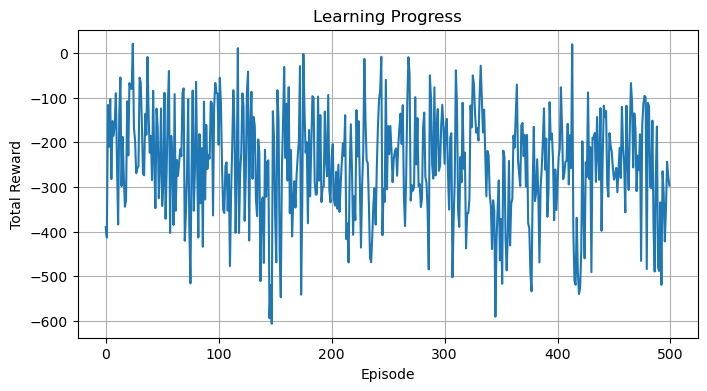

In [15]:
# Regular Features
agentReg = ApproximateQLunarLander(use_engineered_features=False, weights_path='lander_approx_regular_weights.pth')
rewardsReg = agentReg.repeat(episodes=500)
agentReg.record_gif('lander_approx_regular.gif')
agentReg.plot_rewards(rewardsReg)

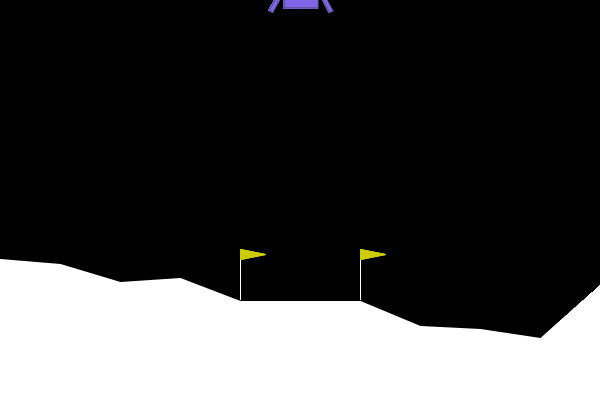

In [19]:
display(Image(filename="lander_approx_regular.gif"))
# https://github.com/suha1419/FinalProjectLunarLander/blob/main/lander_approx_regular.gif

We implement our second Approximate Q-Learning agent with same parameters as the first, but using the following engineered features.
* Distance from center
* Speed
* Angular momentum
* Both legs touching ground
* Lander stability

We see a lot of noise still, but less overall than the first agent. Additionally we see a few instances where the agent was able to achieve high positive scores.

Training: 100%|███████████████████████████████| 500/500 [01:23<00:00,  5.95it/s]


Weights saved to lander_approx_engineered_weights.pth
GIF saved to lander_approx_engineered.gif


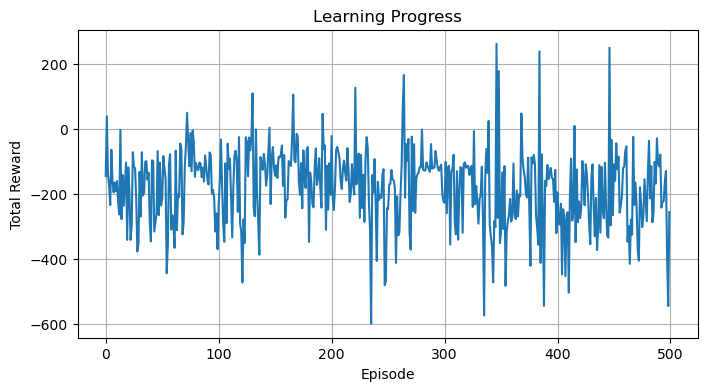

In [13]:
# Engineered Features
agentEng = ApproximateQLunarLander(use_engineered_features=True, weights_path='lander_approx_engineered_weights.pth')
rewardsEng = agentEng.repeat(episodes=500)
agentEng.record_gif('lander_approx_engineered.gif')
agentEng.plot_rewards(rewardsEng)

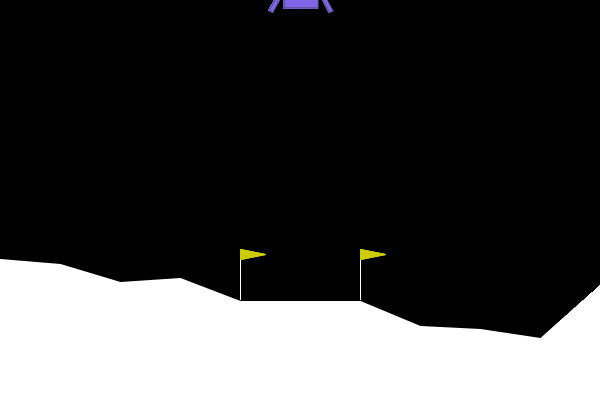

In [18]:
display(Image(filename="lander_approx_engineered.gif"))
#https://github.com/suha1419/FinalProjectLunarLander/blob/main/lander_approx_engineered.gif

#### Deep Q Learning

In [84]:
import random
import torch.optim as optim
from dqn import DQN
from experience_replay import ReplayMemory

# Use M2 GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


class Agent:
    def __init__(self, env, hidden_layers=[64, 64], learning_rate=1e-4, discount=0.99, eps_start=1.0, eps_end=0.05, eps_decay=0.9995,
                 replay_memory_size=10000, batch_size=32, network_sync_rate=1000, seed=42, weights_path='dqn_weights.pth'):
        self.env = env
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.discount = discount
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.replay_memory_size = replay_memory_size
        self.batch_size = batch_size
        self.network_sync_rate = network_sync_rate
        self.loss_fn = nn.MSELoss()
        self.optimizer = None
        self.seed = seed
        self.initialize_networks()

    def initialize_networks(self):
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n
        self.policy_dqn = DQN(num_states, num_actions, self.hidden_layers).to(device)
        self.target_dqn = DQN(num_states, num_actions, self.hidden_layers).to(device)
        self.target_dqn.load_state_dict(self.policy_dqn.state_dict())
        self.optimizer = optim.Adam(self.policy_dqn.parameters(), lr=self.learning_rate)

    
    def select_action(self, state, policy_dqn, epsilon, is_training):
        """
        Select a random action or follow the policy provided by DQN.
        Probability of you selecting a random action is based on epsilon.
        Load the action into the GPU and return
        """
        # SELECT RANDOM ACTION OR USE POLICY
        if is_training and random.random() < epsilon:
            action = self.env.action_space.sample()
            return torch.tensor(action, dtype=torch.int64, device=device)                 
        else:
            with torch.no_grad():
                state.to(device)
                return policy_dqn(state.unsqueeze(0)).squeeze().argmax()
    

    def play_episode(self, policy_dqn, target_dqn, memory, epsilon, is_training):
        """
        Play single episode and return cumulative reward and steps
        """
        state, _ = self.env.reset(seed=self.seed)
        state = torch.tensor(state, dtype=torch.float, device=device)
        done = False
        episode_reward = 0.0
        step_count = 0

        while not done:
            
            # DETERMINE ACTION
            action = self.select_action(state, policy_dqn, epsilon, is_training) # Done

            # ITERATE THROUGH GAME
            new_state, reward, terminated, truncated, _ = self.env.step(action.item()) # Done
            new_state = torch.tensor(new_state, dtype=torch.float, device=device) # to tensor
            reward = torch.tensor(reward, dtype=torch.float, device=device) # to tensor
            done = terminated or truncated

            # CUMULATIVE TOTAL REWARD
            episode_reward += reward.item()


            # SAVE RESULTS FOR NETWORK TRAINING
            if is_training:
                memory.append((state, action, new_state, reward, done))
                step_count += 1

            # UPDATE CURRENT STATE AND CONTINUE LOOP
            state = new_state

        return episode_reward, step_count



    def update_network(self, memory, policy_dqn, target_dqn):
        """
        Updates the policy network (policy_dqn) using targets calculated from the target network (target_dqn).
        """

        # SAMPLE A MINI-BATCH FROM EXPERIENCE REPLAY MEMORY
        mini_batch = memory.sample(self.batch_size)

        # LOAD BATCH DATA INTO GPU
        states, actions, next_states, rewards, dones = zip(*mini_batch)
        states = torch.stack(states)
        actions = torch.stack(actions)
        next_states = torch.stack(next_states)
        rewards = torch.stack(rewards)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        # CALCULATE TARGET Q-VALUES
        with torch.no_grad():
            # GET MAX Q-VALUE FOR NEXT STATES FROM TARGET NETWORK
            max_next_q = target_dqn(next_states).max(dim=1)[0]
            
            # COMPUTE THE TARGET USING THE BELLMAN EQUATION
            target_q = rewards + (1 - dones) * self.discount * max_next_q

        # GET CURRENT Q-VALUES PREDICTED BY THE POLICY NETWORK
        current_q = policy_dqn(states).gather(1, actions.unsqueeze(1)).squeeze()

        # COMPUTE LOSS BETWEEN CURRENT PREDICTION AND TARGET, THEN UPDATE POLICY NETWORK
        loss = self.loss_fn(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss
    
    def run(self, episodes=10, is_training=True):

        # INITIALIZE HISTORY VARIABLES
        reward_per_episode = []
        epsilon_history = []
        loss_per_update = []

        # INITIALIZE PARAMETERS FOR TRAINING
        if is_training:
            memory = ReplayMemory(self.replay_memory_size)
            epsilon = self.eps_start
            total_steps = 0


        # EPOCH LOOP
        for episode in trange(episodes, desc="Training", leave=True):

            # SIMULATE EPISODE AND TRACK RESULT
            episode_reward, step_count = self.play_episode(self.policy_dqn, self.target_dqn, memory, epsilon, is_training)
            reward_per_episode.append(episode_reward)

            # UPDATE DECAY AND SYNC NETWORKS
            if is_training:
                
                # DECAY EPSILON
                epsilon = max(epsilon * self.eps_decay, self.eps_end)
                epsilon_history.append(epsilon)
                
                # TRAIN AND UPDATE NETWORK WHEN BUFFER IS FULL
                if len(memory) > self.batch_size:
                    lpr = self.update_network(memory, self.policy_dqn, self.target_dqn)
                    loss_per_update.append(lpr.item())

                # SYNCHRONIZE NETWORKS
                total_steps += step_count
                if total_steps >= self.network_sync_rate:
                    self.target_dqn.load_state_dict(self.policy_dqn.state_dict())
                    total_steps = 0

        self.env.close()
        return reward_per_episode, epsilon_history, loss_per_update


    def save_weights(self):
        torch.save(self.policy_dqn.state_dict(), self.weights_path)
        print(f"Weights saved to {self.weights_path}")

    def load_weights(self):
        self.policy_dqn.load_state_dict(torch.load(self.weights_path))
        self.policy_dqn.to(device)
        self.policy_dqn.eval()
        print(f"Weights loaded from {self.weights_path}")

    def plot_rewards(self, rewards):
        plt.figure(figsize=(10,5))
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress')
        plt.grid()
        plt.show()

    def record_gif(self, filename='dqn_lander.gif', max_steps=500):
        frames = []
        state, _ = self.env.reset(seed=self.seed)
        state = torch.tensor(state, dtype=torch.float32, device=device)
        done = False

        for _ in range(max_steps):
            frame = self.env.render()
            frames.append(frame)
            action = self.select_action(state, self.policy_dqn, epsilon=0.0, is_training=False)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            done = terminated or truncated
            state = next_state

            if done:
                break

        imageio.mimsave(filename, frames,fps=30)
        print(f"GIF saved to {filename}")

Using device: mps


We implement our Deep Q Learning Agent with the following hyperparameters:
* hidden_layers=[64, 64] 
* learning_rate=1e-3 
* discount=0.99 
* eps_start=1.0 
* eps_end=0.05
* eps_decay=0.9995
* replay_memory_size=10000
* batch_size=32
* network_sync_rate=1000
* seed=42
* Episodes=500

A few notes:
We started the episilon with 0.5 to have a balance between exploration and exploitation. In previous runs, we saw high exploration (high episilon) resulted in poor performance. We compared 1.0, 0.7, and 0.5 and observed 0.5 to perform best within the episode constrains we are evaluting.

We include two hidden layers each of size 64. Our Neural Network will have the following architecture:

Input Row: 8 (size of obervation array)
-> Hidden Layer: 64
-> ReLU Layer
-> Hidden Layer: 64
-> ReLU Layer
-> Output Row: 4 (size of action space)

Our neural network is directly trying to match states with actions in a model-free way, thus we are not engineering any features.


Training: 100%|███████████████████████████████| 500/500 [00:53<00:00,  9.36it/s]


GIF saved to lander_dqn_ag1.gif


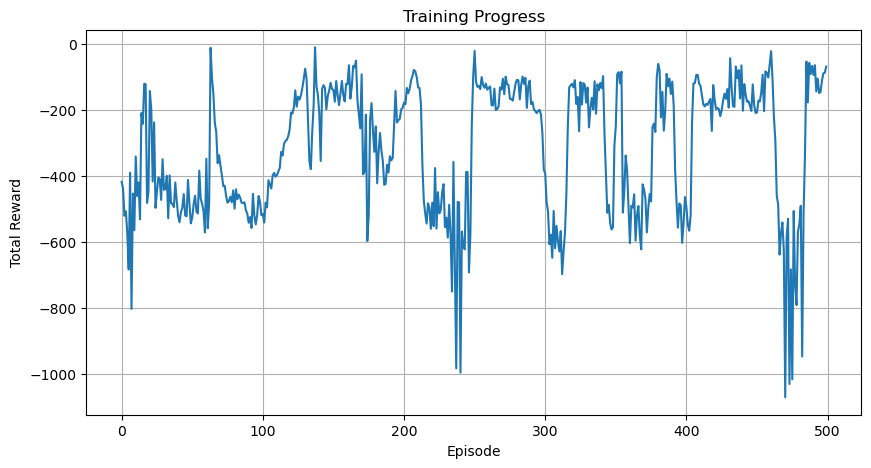

In [22]:
agent1 = Agent(gym.make("LunarLander-v2",render_mode='rgb_array'), hidden_layers=[64,64], learning_rate=1e-3, eps_start=0.5,seed=42)
r,e,l = agent1.run(episodes=500, is_training=True)
agent1.record_gif('lander_dqn_ag1.gif')
agent1.plot_rewards(r)

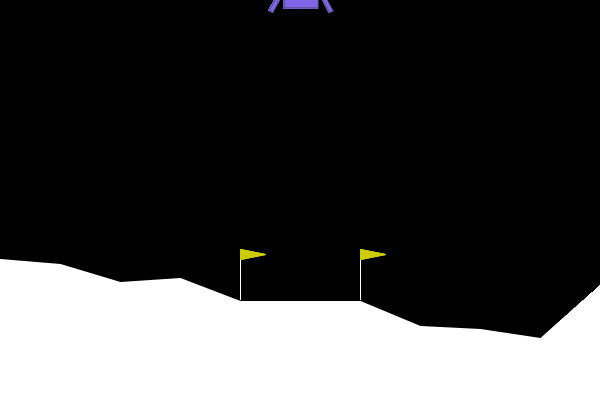

In [82]:
display(Image(filename="lander_dqn_ag1.gif
#https://github.com/suha1419/FinalProjectLunarLander/blob/main/lander_dqn_ag1.gif

#### Results

(-1000.0, 200.0)

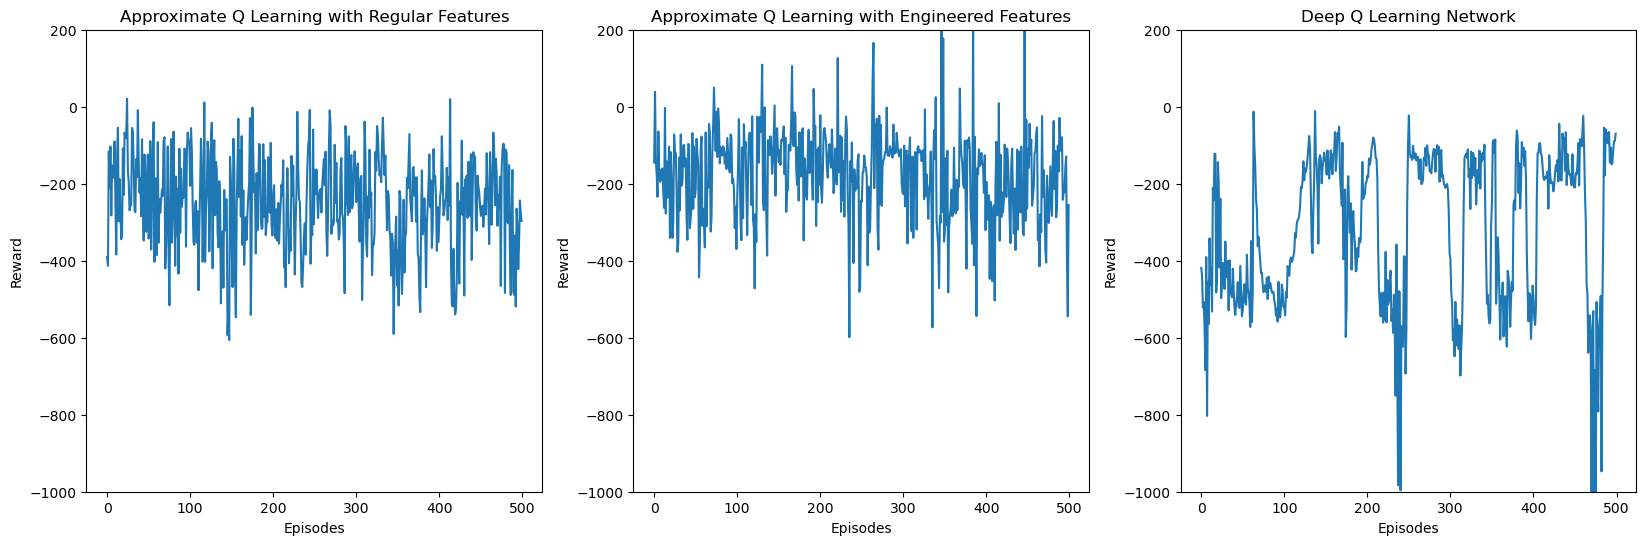

In [73]:
fig, ax = plt.subplots(1,3, figsize=(20,6))
ax[0].plot(rewardsReg)
ax[0].set_title("Approximate Q Learning with Regular Features")
ax[0].set_xlabel("Episodes")
ax[0].set_ylabel("Reward")
ax[0].set_ylim(ymin=-1000,ymax=200)

ax[1].plot(rewardsEng)
ax[1].set_title("Approximate Q Learning with Engineered Features")
ax[1].set_xlabel("Episodes")
ax[1].set_ylabel("Reward")
ax[1].set_ylim(ymin=-1000,ymax=200)

ax[2].plot(r)
ax[2].set_title("Deep Q Learning Network")
ax[2].set_xlabel("Episodes")
ax[2].set_ylabel("Reward")
ax[2].set_ylim(ymin=-1000,ymax=200)

In [12]:
from IPython.display import HTML
HTML("""
<div style="display: flex; justify-content: center;">
    <img src="lander_approx_regular.gif" style="width: 300px; margin-right: 10px;" loop=infinite>
    <img src="lander_approx_engineered.gif" style="width: 300px; margin-right: 10px;" loop=infinite>
    <img src="lander_dqn_ag1.gif" style="width: 300px;" loop=infinite>
</div>
""")

Approximate Q Learning with Regular Features:
1) We dont see any structural improvements with continuing episodes
2) Only a few managed to break above 0 reward
3) Weights seemed to learn and improve performance around the 300th episode, but degrade shortely thereafter

Approximate Q Learning with Engineered Features:
1) We see varying performance improvements and less noise at parts, but ultimately doesnt converge
2) A few samples did acheive a 200 reward indicating it won the game, but seemed to diverge in weights after

Deep Q Learning:
1) We see some convergence to a more optimal policy and there is a structural improvment in performance. However it goes through periods of decay as well.
2) There is less noise in the result which seems interesting
3) None of the episodes were able to win the game

#### Conclusion

There are a few conclusions we can derive from this experiment

**Total reward vs episodes alone is not sufficient for evaluating progress:**
* Initial results were discouraging as we expected the total rewards chart(s) to drive towards 200 points indicating the agent has learned how to win the game
* Since that didn't happen, we thought the agent wasnt learning anything, but after examining video we do see behaviors of landers that show some learning was occurring
* With more training, or different hyperparameters, the agent could start to converge on a policy that achieves high reward each episode

**Feature Engineering is an art and can help the performance of a model if done well:**
* Feature engineering requires domain experience and intuition to develop heuristics that can orient agent to have optimal behaviors
* Weights for each feature will be different, and setting to all 0 initialize may take too long to learn. For important features, it may be better to intiialize weights to a higher value.
* We can see improved performance between the Approximate Q-Learning models, where the feature engineered agent had more stability and higher episode rewards.

**Deep Q Networks are needed for high-dimensional environments, Linear Approxmimate Q-Learning is not sufficient:**
* The observation space was continuous along 6 dimensions, and boolean for 2 dimensions. There is a very large state-space associated with this.
* Almost certianly there are non-linear dynmaics at play, and the DQN seems to do a better job of capturing the subtitles more than the appoximate Q-learning Agetns

**DQN learned intermittent dynamics during the course of our training without being explicitly trained on features.**
* It seemed to learn that the longer the game, the less the reward so it needs to complete the game faster
* It let gravity do most of the work and only fired main engine thursters towards the end to avoid a crash landing
* It learned that closer to the goal was better.
* It learned stability of the lander was better.
* All in all, more training would result in more learning, but the main takeaway is it learned quite a bit in 500 episodes and was not explicitly trained on any feature.


**There are a number of things we could change to improve the performance**
* Tune standard hyperparameters of discount, learning rate, epsilon greedy start and decay 
* Increase episodes for training
* Change size of Neural Network
* Adjust Network Synch Rate and Buffer Size
* Rescale the reward function. Rewards in Lunar Lander are heavily penalized with few examples of positive performance. We could rescale the reward in a way that preserves the optimal policy dynamics, such as a [-1 1] scaling.


#### References and Links

[1] https://gymnasium.farama.org/environments/box2d/lunar_lander/

[2] Friendly Introduction to Deep Reinforcemnt Learning: https://www.youtube.com/watch?v=SgC6AZss478

[3] https://github.com/johnnycode8/dqn_pytorch. Youtube: https://www.youtube.com/watch?v=arR7KzlYs4w&list=PL58zEckBH8fCMIVzQCRSZVPUp3ZAVagWi&index=2

[4] https://pytorch.org/docs/stable/torch.html
